In [1]:
from lab1_tools import trfbank, tidigit2labels, lifter
from lab1_proto import enframe, preemp, windowing, powerSpectrum, logMelSpectrum, cepstrum, dtw, mspec, mfcc

import numpy as np
import matplotlib.pyplot as plt
import sklearn.mixture as mix
from scipy.spatial.distance import cdist as euclidean
from scipy.cluster.hierarchy import linkage, dendrogram


In [2]:
def display_pcolormesh(arr, title="", color=False, x="", y=""):
    plt.figure(figsize = (12,6))
    plt.title(title)
    plt.pcolormesh(arr.T)
    if color:
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

# Main test code

## 1) Load dataset

In [3]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
samples = example['samples']
samplingrate = example['samplingrate']

In [4]:
#data = np.load('lab1_data.npz', allow_pickle=True)['data']
#data
#samplingrate = data['samplingrate']

# 4) MFCCs (Mel Frequency Cepstrum Coefficients) step-by-step

## 4.1) Enframe sample

In [5]:
# Enframing ensures that each frame is quasi-stationary (i.e. 
# statistical properties roughly stationary in small window), allowing for
# more reliable feature extraction (with windowing, FFT, etc.). Slices input samples into
# overlapping windows.

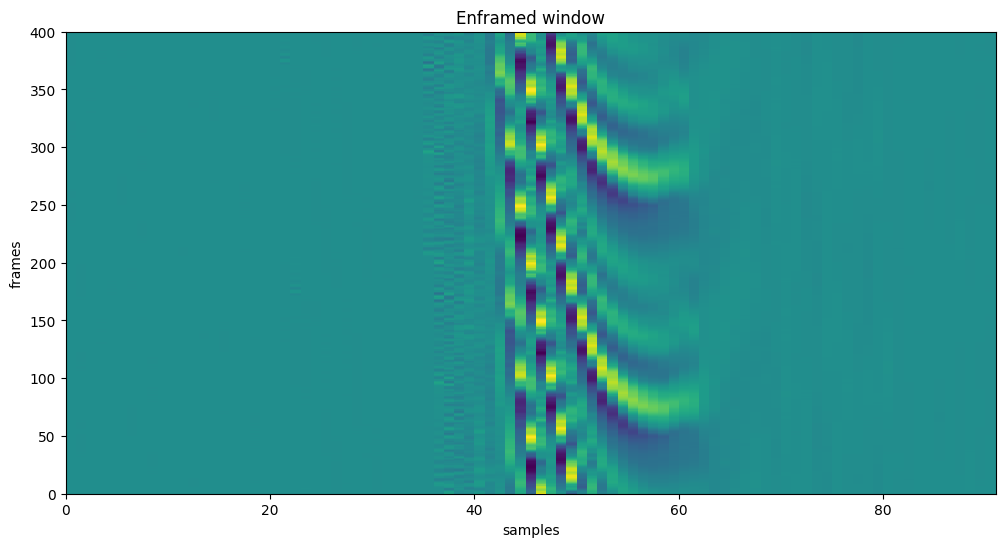

In [6]:
window_lenth, window_shift = int(samplingrate * 0.02), int(samplingrate * 0.01)

enframed = enframe(samples, window_lenth, window_shift)

display_pcolormesh(enframed, title="Enframed window", y="frames", x="samples")

# 4.2) Pre-emphasis

In [7]:
# pre-emphasis is a digital filter applied to a signal to increase
# the amplitude of high-freq. components relative to lower-freq. compoennts.
# Some purposes:
    # 1) Improves SNR: high frequency typically more susceptible to
    # noise, by emphasizing these sounds subsequent steps have
    # an easier time detecting and analyzing them. I.e., compensating
    # for spectral tilt.

    # 2) Makes formants (F1, F2, resonant frequencies of vocal tract) 
    # more pronounced by reducing dominance of low-frequency components.

# The filter is typically a first-order FIR filter: y[n] = (1-alpha) * x[n] + alpha * x[n-1],
# x[n] input signal, y[n] filtered output, alpha pre-emphasis coefficient (< 1, 0.97 in our case).

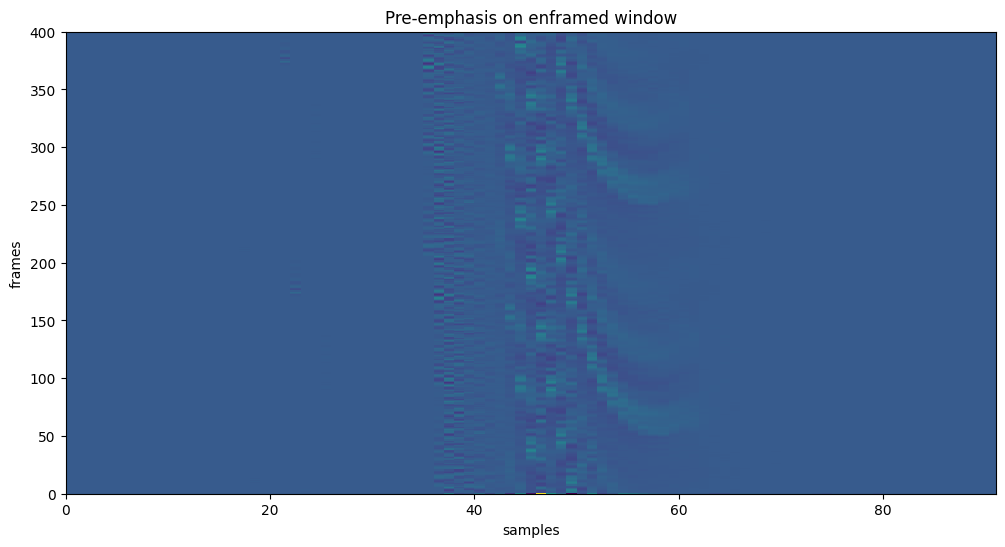

In [8]:
pre_emphed = preemp(enframed, p=0.97)
display_pcolormesh(pre_emphed, title="Pre-emphasis on enframed window", y="frames", x="samples")

# 4.3) Hamming Window

In [9]:
# A window function is some mathematical function which is zero outside
# of some chosen interval. In signal processing, purposes:
    # 1) Minimize spectral leakge: Fourier analysis on finite segments assumes segments 
    # repeat infinitely. Sounds typically don't, so we get discontinuities at the boundaries, which causes spectral leakage
    # where energy from one component leaks over to another. A window function removes these discontinuities.

    # 2) Improved frequency resolution: Concentrates signal's energy into narrower main lobe, easier to 
    # distinguish between closely spaced frequency components.

# typical Formulation for (generalized) Hamming window h_h[n] given below:

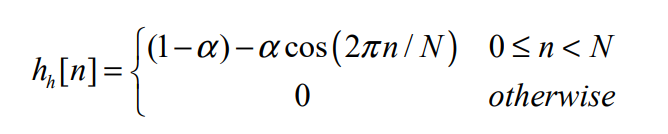

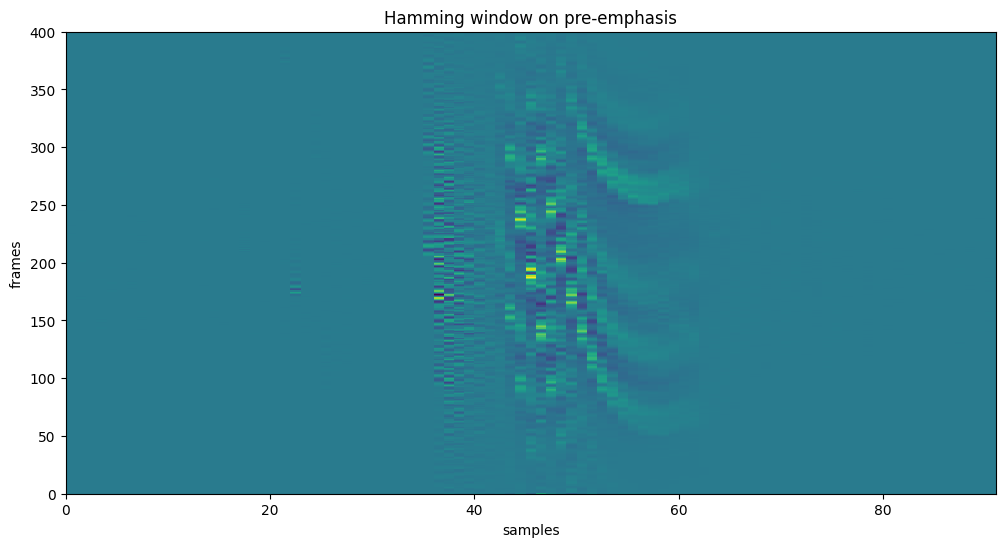

In [10]:
windowed = windowing(pre_emphed)
display_pcolormesh(windowed, title="Hamming window on pre-emphasis", y="frames", x="samples")

# 4.4) Fast Fourier Transform (FFT)

In [11]:
# FFT is an algorithm which computes DFT (Discrete Fourier Transform) efficiently.
# From O(N^2) to O(NlogN).
# The power spectrum of a signal representes the distribution of power (or variance)
# across different frequency components. 

# We consider only components until Nyquist point, as per the sampling theorem.
# The frequency bin at nfft/2 (256) corresponds to f_max.
# The Mel filterbank expects a whole spectrum, so we return both the power spectrums.

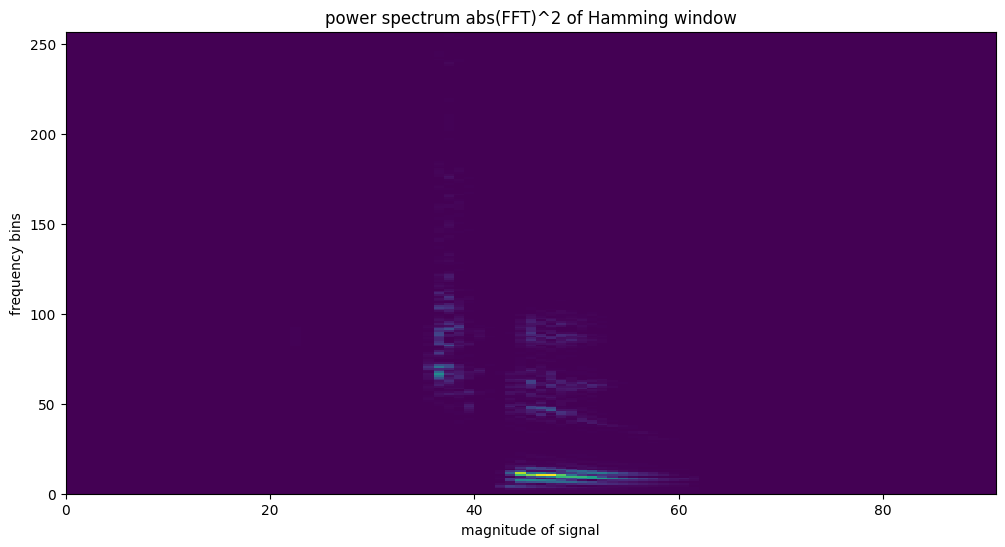

In [12]:
powerSpec, powerSpecNyquist = powerSpectrum(windowed, nfft=512)
display_pcolormesh(powerSpecNyquist, title="power spectrum abs(FFT)^2 of Hamming window", y="frequency bins", x="magnitude of signal")

# 4.5) Mel filterbank log spectrum

In [13]:
# The mel scale is a perceptual scale of pitches judged by listerns to be 
# equal distance from one another. Helps in extracting features that are
# more relevant for distinguishing phonemes.

# Logarithmic scaling is applied beacuse it corresponds to a compression 
# of the dynamic range, which is more in line with human auditory perception.

# "trtbank" generates a tringular filterbank, which are spaced according to 
# the Mel scale. Because of logarithmic nature of Mel scale, many trinagles 
# at low frequencies and fewer at high frequencies.

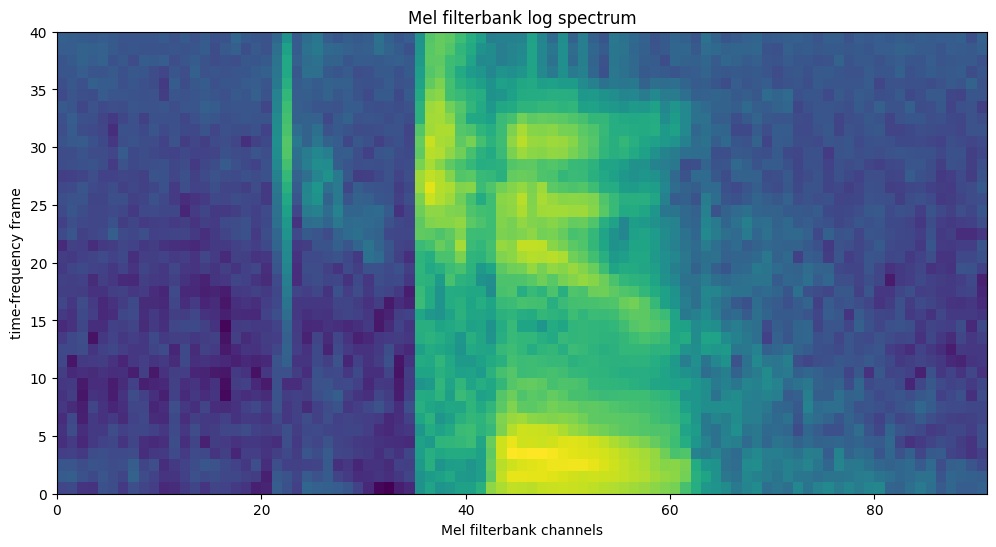

In [14]:
log_mel_spec = logMelSpectrum(powerSpec, samplingrate)
display_pcolormesh(log_mel_spec, title="Mel filterbank log spectrum", y="time-frequency frame", x="Mel filterbank channels")

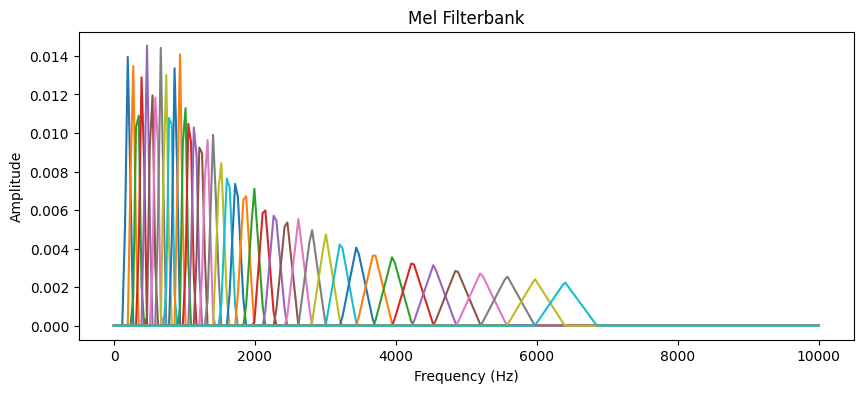

In [15]:
nfft = powerSpec.shape[1]
mel_filters = trfbank(samplingrate, nfft)

# The frequency axis should match the number of points in each filter
frequency_axis = np.linspace(0, samplingrate // 2, nfft // 2 + 1)

plt.figure(figsize=(10, 4))
for mel_filter in mel_filters:
    plt.plot(frequency_axis, mel_filter[:len(frequency_axis)])
plt.title('Mel Filterbank')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

# 4.6) (Discrete) Cosine Transform and Liftering

In [16]:
# DCT helps de-correlate the log Mel spectrum coefficients and tends to compact 
# energy into the lower part of the spectrum. Cepstral liftering is applied 
# in order to scale the high-order coefficients in comparison to low-order 
# ones. Together, these methods are vital for MFCC feature extraction, helping 
# to create features that are well-suited for subsequent statistical models.

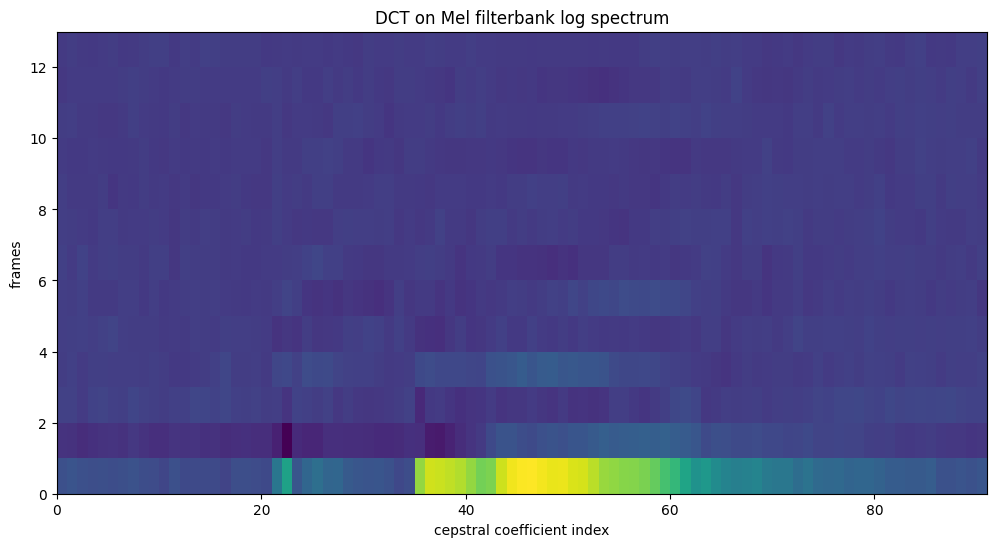

In [17]:
cep_coeff = cepstrum(log_mel_spec, nceps=13)
display_pcolormesh(cep_coeff, title="DCT on Mel filterbank log spectrum", y="frames", x="cepstral coefficient index")

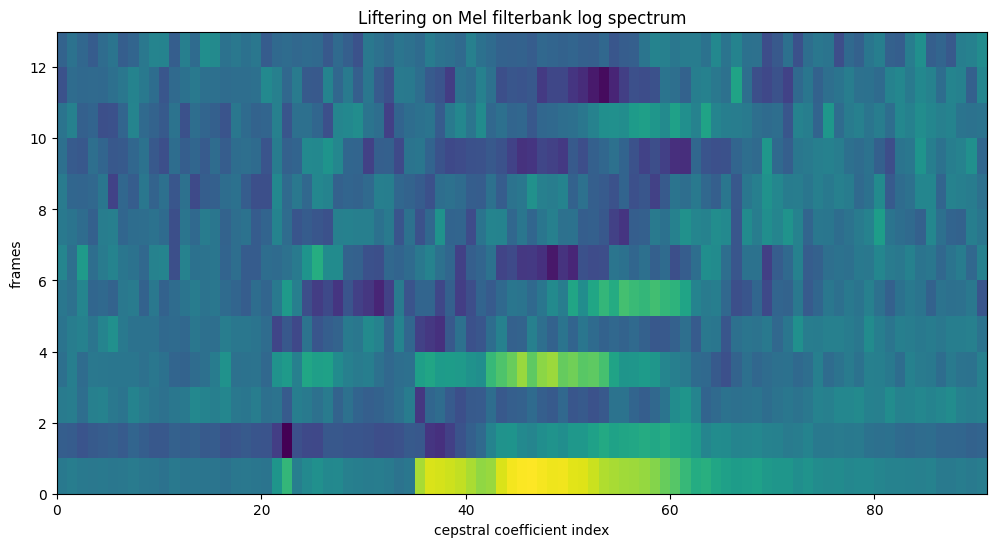

In [18]:
liftered = lifter(cep_coeff, 22)
display_pcolormesh(liftered, title="Liftering on Mel filterbank log spectrum", y="frames", x="cepstral coefficient index")

# 5) Feature Correlation

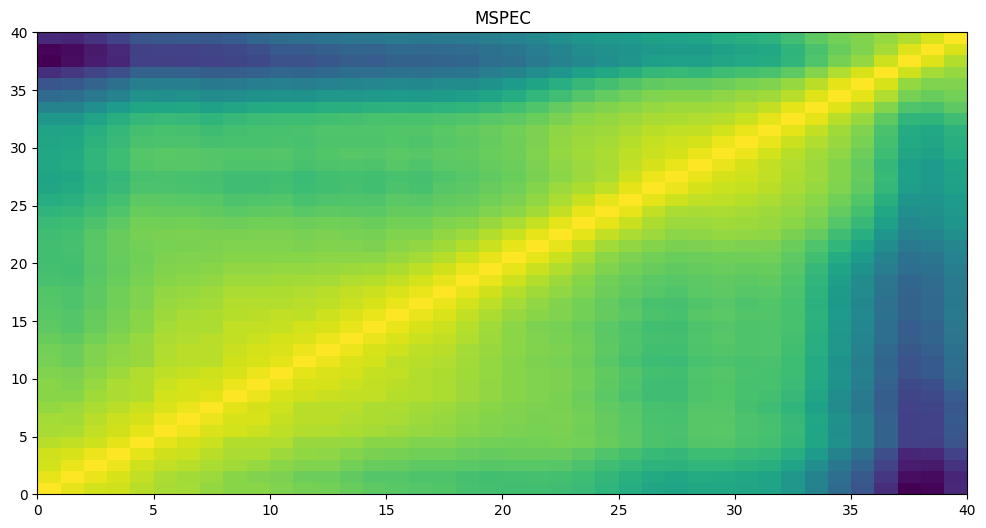

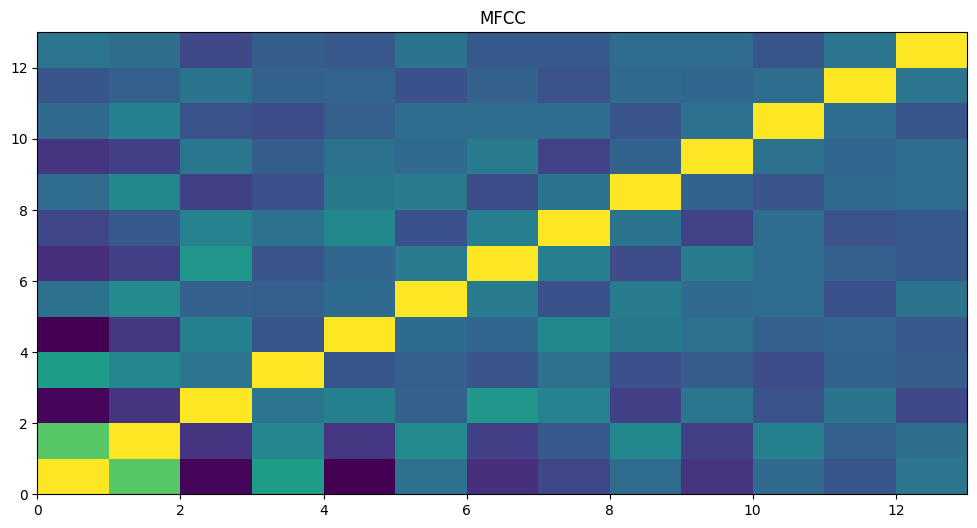

In [19]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
mfcc_utterances = [mfcc(utterance['samples']) for utterance in data]
mspec_utterances = [mspec(utterance['samples']) for utterance in data]

# vstack = 'vertical stack', stacks sequentlly in vertical order
mfcc_data = np.vstack(mfcc_utterances)
mspec_data = np.vstack(mspec_utterances)

# 
mfcc_r = np.corrcoef(mfcc_data, rowvar=False)
mspec_r = np.corrcoef(mspec_data, rowvar=False)

display_pcolormesh(mspec_r, "MSPEC")
display_pcolormesh(mfcc_r, "MFCC")

* Are features correlated?

(MFCC Features): Diagonal ones are yellow, non-diagonal fairly blue, suggests low correlation between different features. 

(Mel Filterbank Features): Shows a gradient of blue to yellow, features up to ~ 32 appear to be correlated with each other. Also high correlation in features >=36.

* Is the assumption of diagonal covariance matrices
for Gaussian modelling justified?

For MFFC features, assumption of diagonal covariance matrices for Gaussian models seems more justifiable because the features appear uncorrelated.

For the Mel Filterbank features, the higher degree of correlation between features implies that the assumption of independence (and thus diagonal covariance matrices) is less valid.

MSPEC vs MFCC: MSPEC applies a bank of triangular filters that are evenly spaced on a Mel scale to the power spectrum of a signal. MFCC applies DCT to MSPEC, effectively compressing the spectrum and highlighting parts that are most important for human perception. Sometimes, 'liftering' is applied to MFCCs to emphasize higher-order coeffs, which can be beneficial in speech recognition tasks.

# 6) Explore Speech Segments with Clustering

Posterior Probability for GMM with 32 components, utterance #16:
[[1.62575048e-001 7.56824817e-011 2.39443716e-002 4.94824849e-020
  5.08492553e-002 3.58486020e-020 5.82075572e-124 3.17061728e-005
  1.27399983e-040 1.21965689e-002 2.87654434e-006 8.80849301e-007
  1.43635640e-020 5.73719351e-013 1.10384382e-033 2.07838186e-018
  2.71573830e-038 2.78696387e-014 3.41984389e-007 1.43871408e-001
  5.14527954e-002 8.81766848e-002 4.07928698e-016 1.08743734e-002
  5.43475880e-002 7.86498903e-002 1.40126819e-002 4.09531844e-002
  6.52153824e-002 2.89351486e-002 2.89360276e-009 1.73909810e-001]]


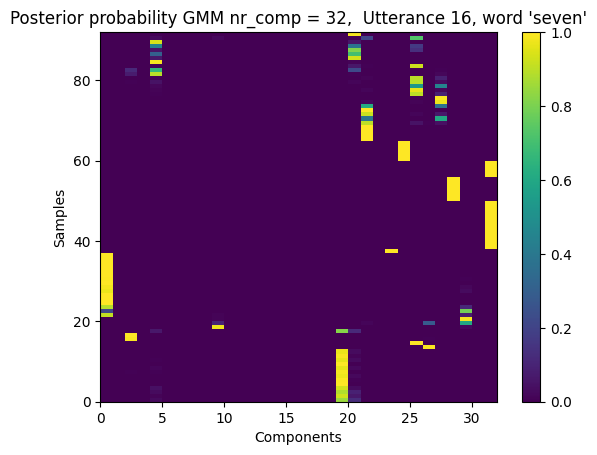

Posterior Probability for GMM with 32 components, utterance #17:
[[1.45794512e-001 8.69109134e-007 1.33595477e-002 1.94890970e-032
  1.05002031e-001 4.76360116e-024 3.59188204e-108 2.64420998e-007
  1.06136071e-036 2.28151318e-002 1.10957618e-006 3.24560772e-008
  2.21953025e-020 3.41274724e-009 1.00497688e-023 3.57675316e-021
  3.89742970e-040 1.33470090e-013 1.49392151e-007 1.84971060e-001
  8.24136897e-002 3.77291082e-002 2.95124551e-018 1.05318083e-002
  6.31461716e-002 5.68300438e-002 1.06467462e-002 1.45101155e-002
  7.36228809e-002 2.06742904e-002 7.82073737e-009 1.57950428e-001]]


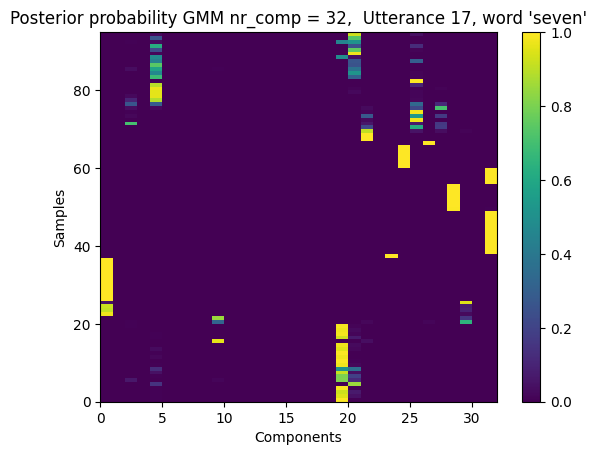

Posterior Probability for GMM with 32 components, utterance #38:
[[1.59064938e-04 3.38949381e-05 3.14759221e-03 1.66723281e-01
  8.37340494e-02 1.03347846e-16 3.87559893e-41 5.88657418e-03
  1.09568970e-37 1.01241538e-02 1.42166808e-01 1.50500718e-01
  1.04919590e-64 9.51433823e-21 1.78284720e-42 2.87858252e-22
  8.15005080e-15 2.26284888e-19 8.79532199e-02 1.88469088e-02
  4.13858717e-02 2.84103034e-02 1.82539479e-15 1.46794713e-08
  4.33410720e-12 7.71140384e-02 9.64026222e-02 2.01638426e-02
  1.16087871e-06 5.68760954e-02 8.35778274e-08 1.03697018e-02]]


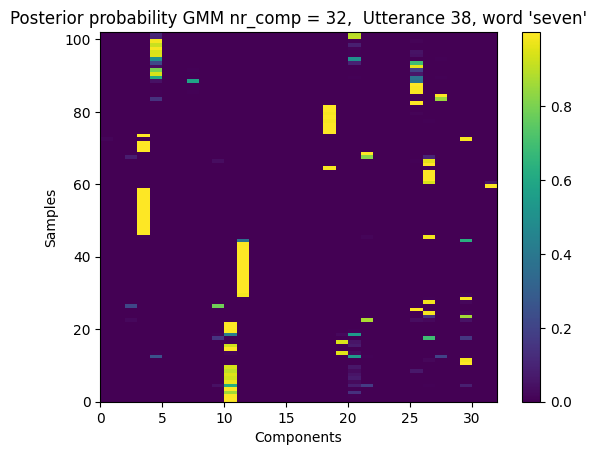

Posterior Probability for GMM with 32 components, utterance #39:
[[1.17308925e-03 2.32659392e-07 1.05463755e-02 1.73423099e-01
  1.33350548e-01 6.01800406e-16 3.15896831e-30 2.15732784e-03
  7.30384351e-53 1.19676511e-02 5.70047445e-02 1.21382347e-01
  1.17838793e-51 2.14389720e-22 8.83184237e-28 4.58837605e-32
  2.88041684e-35 3.45261691e-22 9.12263967e-02 2.01814998e-03
  1.50172059e-01 2.17200962e-02 2.71206151e-12 2.89984500e-04
  6.62387869e-14 4.04906089e-02 8.05302345e-02 1.96491511e-04
  6.14064564e-08 7.04672707e-02 6.90885060e-05 3.18141433e-02]]


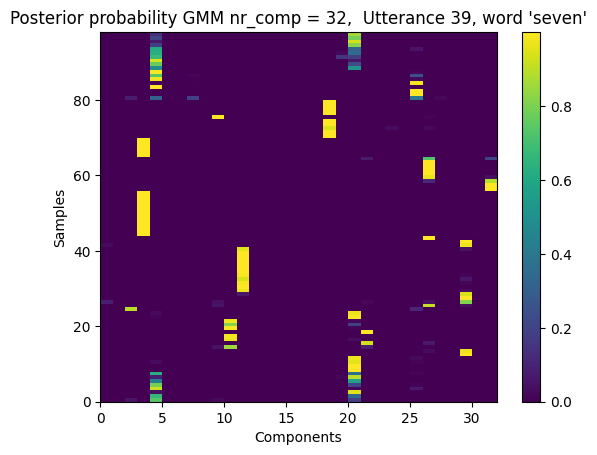

In [20]:
def plotPosterior(posterior, n_components, ut_index):
    # Normalize summed posterior
    norm_sum_posterior = np.sum(posterior, axis=0, keepdims=True) / np.sum(posterior)
    print(f"Posterior Probability for GMM with {n_components} components, utterance #{ut_index}:")
    print(norm_sum_posterior)
    
    plt.figure()
    plt.pcolormesh(posterior)
    plt.xlabel("Components")
    plt.ylabel("Samples")
    plt.title(f"Posterior probability GMM nr_comp = {n_components},  Utterance {ut_index}, word 'seven'")
    plt.colorbar()
    plt.show()

def train_gmm(data, n_components):
    gmm = mix.GaussianMixture(n_components=n_components)
    gmm.fit(data)
    return gmm

#components = [4, 8, 16, 32]
components = [32]
utterance_indices = [16, 17, 38, 39]

for component in components:
    gmm = train_gmm(mfcc_data, component)
    for ut_index in utterance_indices:
        posterior = gmm.predict_proba(mfcc_utterances[ut_index])
        plotPosterior(posterior, component, ut_index)

For GMM with nr_comp = 32:

* Can you say something about the classes discovered by the unsupervised learning method?

The GMM learning method appears to have chosen some classes which tend to be characteristic for the word 'seven', although most classes tend to vary more or less for different utterances.

* Do the classes roughly correspond to the phonemes you expect to compose each word?

Whether or not the classes correspond to phonemes is difficult to say. Consistently active patterns, such as the ones mentioned above, are probably capturing various phonetic features of the word 'seven'. Since the word 'seven' consists of 3-4 phonemes (/s/, /ɛ/, /vən/ and possibly /n/) we expect to se 3-4 dominant components, yet all heat maps have more than 4 predominantly active areas, suggesting the presence of e.g. noise and/or various speaker-specific characteristics.

* Are those classes a stable representation of the word if you compare utterances from different speakers?

When comparing different speakers for nr_comp = 32, we find that utterances 16 and 17 appear to match quite well, and that utterances 38 and 39 match well, but the pair chose slightly different classes. This suggests that the components which appear in roughly all utterances probably encode features for 'seven' quite well, whereas everything else is due to other factors. It is moreover possible that one pair is spoken by the male speaker and the other by the female speaker, which would explain this difference.

# 7) Comparing Utterances

## Global distances

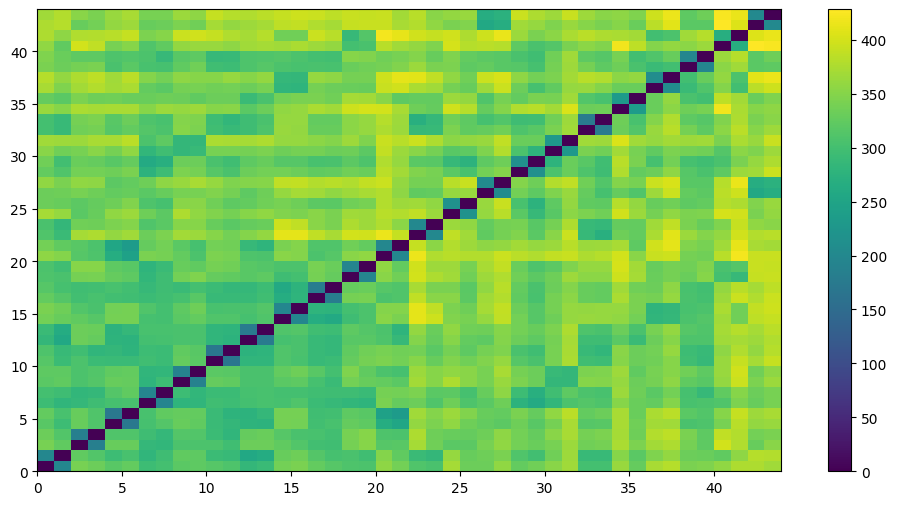

In [21]:
N = len(mfcc_utterances)
D = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        D[i, j] = dtw(mfcc_utterances[i], mfcc_utterances[j], dist=euclidean)[0]

display_pcolormesh(D, color=True)

* Compare distances within the same digit and across different digits. Does the distance separate digits well even between different speakers?

Considering the above figure, the distance does seem to separate the digits well, even between different speakers. Along the main diagonal, the distances are expected to be zero since identical utternace comparisons would not differ much in distance. The off-diagonal variability suggests that the differences across different utternaces vary. Moreover, there appears to be a slightly darker block for utternaces <= 22, although the distnace is still roughly 300. Overall, the separation appears quite good.

## Hierarchical clustering

In [22]:
# linkade calculates hierarchical/agglomerative clustering
# 'complete' method means maximum distance between any two points from two different clusters

/tmp/ipykernel_23929/1539025677.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link_dists = linkage(D, method='complete')


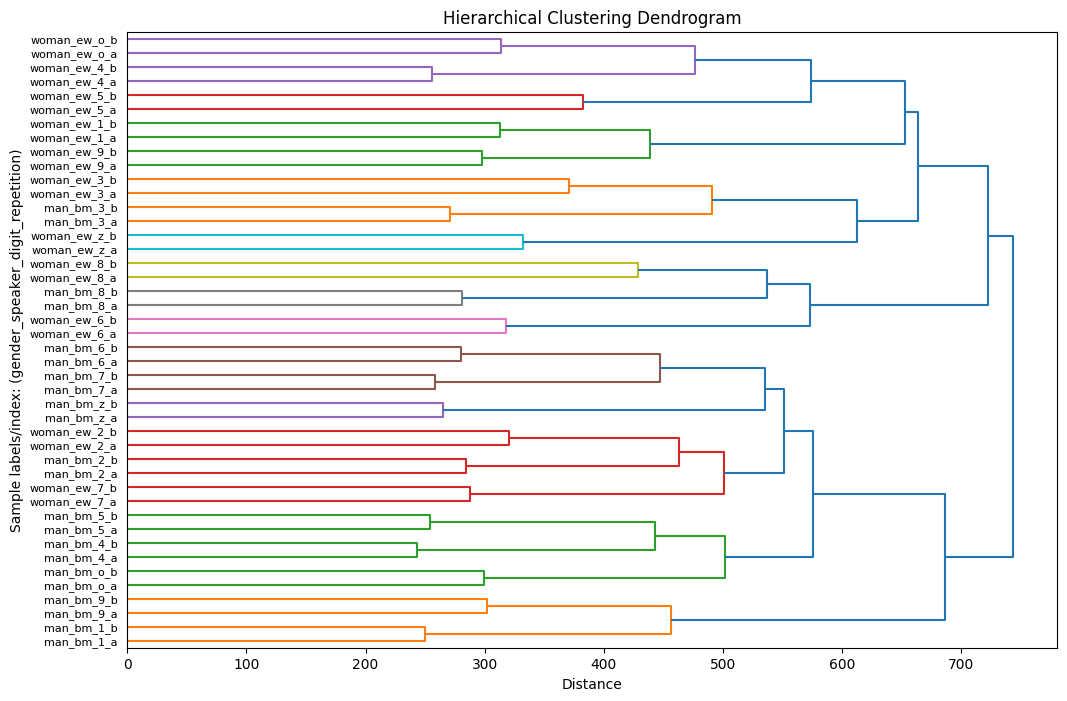

In [23]:
link_dists = linkage(D, method='complete')
labels = tidigit2labels(data)

plt.figure(figsize=(12, 8))
dendrogram(link_dists, labels=labels, leaf_rotation=0, orientation='right')
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Sample labels/index: (gender_speaker_digit_repetition)")
plt.xlabel("Distance")
plt.show()


* Again, does the distance separate speakers digits well even between different speakers?

Kinda. Every a and b repetition for a digit for both speakers are correctly clustered. Ideally, every cluster would work like the ones for digit=3, so that "woman_ew" would match for a and b, and "man_bm" would match for a and b, and both pairs would then match with each other. However, most clusters don't work like this. For instance, digit 1 and 9 appear to have been matched together for the man and the woman in the study, probably because both end in the phoneme \n\\. Other clusters are a bit worse. The clusters for 2 and 7 appear to have been clustered together, surprisingly.

This sort of clustering suggests that various speaker-specific characteristics (e.g. accent, tone of voice, mood, etc.) are probably present in the extracted features.